In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [2]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples, s2_samples

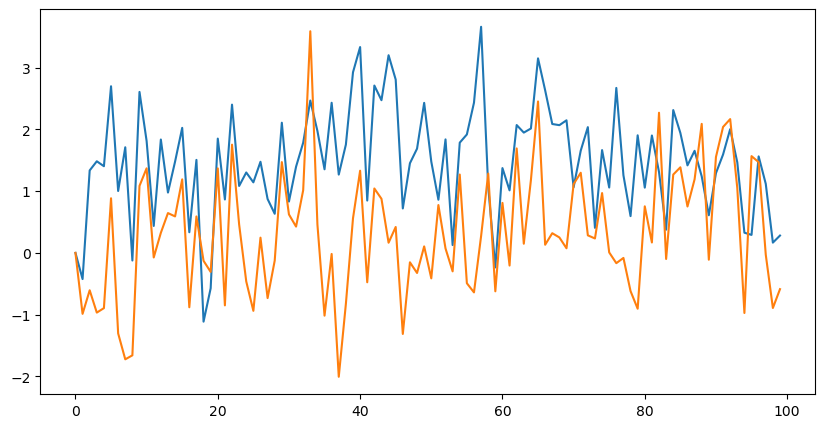

1.4758258618101814
0.3102890336057029


In [21]:
mu_a = np.array([[1, 1]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, 100)
plt.plot(s1)
plt.plot(s2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

print(np.mean(s1))
print(np.mean(s2))


## Tests

In [4]:
# Test sample_s function

t = np.array([[1]])
mu_a = np.array([[1, 1]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
s1, s2 = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)

print(s1, s2)

1.8989425290652888 1.2701066451009513


In [5]:
# Test sample_t function
y = 1
t = sample_t(1, s1, s2, sigma_ba)
print(t)

1.2237431029955084
